# Exercício Multiagents
  
Aluno: Maria Fernanda Bosco  
RA: 183544  

Fazer um agente que responde perguntas sobre a declaração anual do imposto de renda usando LangChain.
   
Base de dados: https://huggingface.co/datasets/unicamp-dl/BR-TaxQA-R.

Usar questions como base de teste.
Usar referred_legal_documents_QA_2024_v1.0 como base de busca.
  
Busca:
- Embeddings usando FAISS
- Janelamento dos documentos: usar langchain

Avaliação:
- Usar BERTScore para avaliar usando as respostas originais como referência
- Avaliar as referências usadas (F1)
- Avaliar pelo menos as 100 primeiras perguntas.

Fazer um chatbot capaz de responder a perguntas sobre a declaração do imposto de renda usando sistema multiagente.  
  
Requisitos: Usar pelo menos 2 agentes.
  
Sugestão: Agente buscador (do exercício anterior) + Agente redator (Definir humor: alegre, triste, grosso, etc.).

Usar Langgraph, Autogen, Crew-AI ou outro framework multiagent.   
Salvar memória (histórico de conversa).   
Ter interface (streamlit, gradio, etc.).   
  
Avaliação: Como avaliar um chatbot com RAG? Considerando que eu não tenho respostas de referência. Ou seja, sem dataset.


# Imports

In [ ]:
# Importações necessárias
import os
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any
from datasets import load_dataset
import datasets
import json

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.agents import create_react_agent, AgentExecutor
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Hugging Face e outros
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer
import faiss

# Configurações
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

/Users/mabosco/Desktop/mestrado/IA368HH/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SetUp

In [ ]:
# Modelo de embedding
EMBEDDING_MODEL = "multi-qa-mpnet-base-cos-v1"

# Parâmetros de chunking
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 50

# Parâmetros de busca
TOP_K_RETRIEVAL = 3

# OpenAI API
OPENAI_BASE_URL = "https://api.openai.com/v1"
GPT_MODEL = "gpt-5-nano"

# Avaliação
NUM_QUESTIONS = 100

# Arquivos
FAISS_INDEX_PATH = "faiss_index.bin"

# Dados

In [ ]:
# Carregamento do dataset BR-TaxQA-R da Hugging Face
print("Carregando dataset BR-TaxQA-R...")

# Carregar o dataset
dataset = load_dataset(
     "json",
    data_files="data/questions_QA_2024_v1.0.json",
    split="train"
)

print("Dataset carregado!")

# Explorar a estrutura do dataset
print(f"Número de exemplos: {len(dataset)}")
print(f"Colunas: {dataset.column_names}")

# Mostrar um exemplo
if len(dataset) > 0:
        example = dataset[0]
        print(f"Exemplo:")
        for key, value in example.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")

Carregando dataset BR-TaxQA-R...
Dataset carregado!
Número de exemplos: 715
Colunas: ['question_number', 'question_summary', 'question_text', 'answer', 'answer_cleaned', 'references', 'linked_questions', 'formatted_references', 'embedded_references', 'formatted_embedded_references', 'all_formatted_references']
Exemplo:
  question_number: 001
  question_summary: OBRIGATORIEDADE
  question_text: Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-cale...
  answer: ['Está obrigada a apresentar a Declaração de Ajuste Anual (DAA) referente ao exercício de 2024, a pessoa', 'física residente no Brasil que, no ano-calendário de 2023:', '1 - recebeu rendimentos tributáveis, sujeitos ao ajuste na declaração, cuja soma foi superior a R$ 30.639,90', '(trinta mil, seiscentos e trinta e nove reais e noventa centavos);', '2 - recebeu rendimentos isentos, não tributáveis ou tributados exclusivamente na fonte, cuja soma foi superior', 'a R$ 200.000,00 (duzent

In [ ]:
dataset[0]

{'question_number': '001',
 'question_summary': 'OBRIGATORIEDADE',
 'question_text': 'Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?',
 'answer': ['Está obrigada a apresentar a Declaração de Ajuste Anual (DAA) referente ao exercício de 2024, a pessoa',
  'física residente no Brasil que, no ano-calendário de 2023:',
  '1 - recebeu rendimentos tributáveis, sujeitos ao ajuste na declaração, cuja soma foi superior a R$ 30.639,90',
  '(trinta mil, seiscentos e trinta e nove reais e noventa centavos);',
  '2 - recebeu rendimentos isentos, não tributáveis ou tributados exclusivamente na fonte, cuja soma foi superior',
  'a R$ 200.000,00 (duzentos mil reais);',
  '3 - obteve, em qualquer mês, ganho de capital na alienação de bens ou direitos sujeito à incidência do imposto;',
  '4 - realizou operações de alienação em bolsas de valores, de mercadorias, de futuros e assemelhadas:',
  'a) cuja soma foi superior a R$ 40.000,00 (q

In [ ]:
print("Carregando base de documentos...")

sources = load_dataset(
    "json",
    data_files="data/referred_legal_documents_QA_2024_v1.0.json",
    split="train"
)

print("Dataset carregado!")

# Explorar a estrutura do dataset
print(f"Número de exemplos: {len(sources)}")
print(f"Colunas: {sources.column_names}")

# Mostrar um exemplo
if len(sources) > 0:
        example = sources[0]
        print(f"Exemplo:")
        for key, value in example.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")

Carregando base de documentos...
Dataset carregado!
Número de exemplos: 478
Colunas: ['filename', 'filedata']
Exemplo:
  filename: ADI RFB nº 12, de 2016.txt
  filedata: NORMAS Contraste   Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado...


In [ ]:
sources[0]

{'filename': 'ADI RFB nº 12, de 2016.txt',
 'filedata': 'NORMAS Contraste \ue88a \ue8ad Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado(a) no DOU de 25/11/2016, seção 1, página 27) Multivigente Vigente Original Relacional Dispõe sobre a isenção de Imposto sobre a Renda nas aplicações em Certificado de Direitos Creditórios do Agronegócio e Certificado de Recebíveis do Agronegócio. O SECRETÁRIO DA RECEITA FEDERAL DO BRASIL, no uso das atribuições que lhe conferem os incisos III e XXVI do art. 280 do Regimento Interno da Secretaria da Receita Federal do Brasil, aprovado pela Portaria MF n 203, de 14 de maio de 2012, e tendo em vista o disposto no art. 3 da Lei n 11.033, de 21 de dezembro de 2004, e no art. 37 da Lei n 11.076, de 30 de dezembro de 2004, declara: Art. 1 Enquadra-se no conceito de remuneração para fins da isenção prevista no inciso IV do art. 3 da Lei n 11.033, de 21 de dezembro de 2004, a parcela da variação cambial paga pelo Certificado de D

In [ ]:
# Selecionar os 100 primeiros itens do dataset
questions_data = dataset.select(range(100))

for item in questions_data:
    # converte a lista answer_cleaned em uma string para ser usada na avaliação
    item['answer_cleaned'] = ' '.join(item['answer_cleaned']).strip()

print("Exemplo de pergunta filtrada:")
print(questions_data[0])

Exemplo de pergunta filtrada:
{'question_number': '001', 'question_summary': 'OBRIGATORIEDADE', 'question_text': 'Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?', 'answer': ['Está obrigada a apresentar a Declaração de Ajuste Anual (DAA) referente ao exercício de 2024, a pessoa', 'física residente no Brasil que, no ano-calendário de 2023:', '1 - recebeu rendimentos tributáveis, sujeitos ao ajuste na declaração, cuja soma foi superior a R$ 30.639,90', '(trinta mil, seiscentos e trinta e nove reais e noventa centavos);', '2 - recebeu rendimentos isentos, não tributáveis ou tributados exclusivamente na fonte, cuja soma foi superior', 'a R$ 200.000,00 (duzentos mil reais);', '3 - obteve, em qualquer mês, ganho de capital na alienação de bens ou direitos sujeito à incidência do imposto;', '4 - realizou operações de alienação em bolsas de valores, de mercadorias, de futuros e assemelhadas:', 'a) cuja soma foi superior a R$ 4

In [ ]:
# Definindo documentos de busca
documents_data = [doc for doc in sources if doc.get('filedata', '').strip()] # remove documentos sem conteúdo

print(f"Total de documentos de busca: {len(documents_data)}")
print(f"Exemplo de documento de busca:")
print(documents_data[0])  # Exemplo de documento de busca

Total de documentos de busca: 478
Exemplo de documento de busca:
{'filename': 'ADI RFB nº 12, de 2016.txt', 'filedata': 'NORMAS Contraste \ue88a \ue8ad Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado(a) no DOU de 25/11/2016, seção 1, página 27) Multivigente Vigente Original Relacional Dispõe sobre a isenção de Imposto sobre a Renda nas aplicações em Certificado de Direitos Creditórios do Agronegócio e Certificado de Recebíveis do Agronegócio. O SECRETÁRIO DA RECEITA FEDERAL DO BRASIL, no uso das atribuições que lhe conferem os incisos III e XXVI do art. 280 do Regimento Interno da Secretaria da Receita Federal do Brasil, aprovado pela Portaria MF n 203, de 14 de maio de 2012, e tendo em vista o disposto no art. 3 da Lei n 11.033, de 21 de dezembro de 2004, e no art. 37 da Lei n 11.076, de 30 de dezembro de 2004, declara: Art. 1 Enquadra-se no conceito de remuneração para fins da isenção prevista no inciso IV do art. 3 da Lei n 11.033, de 21 de dezembro d

# Documentos janelados e FAISS

Importados dos resultados do notebook da semana passada.

In [ ]:
import json

with open("all_chunks.json", "r", encoding="utf-8") as f:
    all_chunks = json.load(f)

print(f"\nDocumentos originais: {len(documents_data)}")
print(f"Chunks gerados: {len(all_chunks)}")

# Mostrar estatísticas dos chunks
chunk_lengths = [len(chunk['chunk_text']) for chunk in all_chunks]
print(f"\nEstatísticas dos chunks:")
print(f"  Tamanho médio: {np.mean(chunk_lengths):.1f} caracteres")
print(f"  Tamanho mínimo: {np.min(chunk_lengths)} caracteres")
print(f"  Tamanho máximo: {np.max(chunk_lengths)} caracteres")

# Mostrar alguns exemplos de chunks
print(f"\nExemplos de chunks:")
for i in range(min(3, len(all_chunks))):
    chunk = all_chunks[i]
    print(f"\nChunk {i+1}:")
    print(f"  Tamanho: {len(chunk['chunk_text'])} caracteres")
    print(f"  Documento: {chunk['filename']}")
    print(f"  Conteúdo: {chunk['chunk_text'][:200]}...")


Documentos originais: 478
Chunks gerados: 19083

Estatísticas dos chunks:
  Tamanho médio: 821.4 caracteres
  Tamanho mínimo: 3 caracteres
  Tamanho máximo: 1000 caracteres

Exemplos de chunks:

Chunk 1:
  Tamanho: 829 caracteres
  Documento: ADI RFB nº 12, de 2016.txt
  Conteúdo: NORMAS Contraste   Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado(a) no DOU de 25/11/2016, seção 1, página 27) Multivigente Vigente Original Relacional Dispõe sobre ...

Chunk 2:
  Tamanho: 807 caracteres
  Documento: ADI RFB nº 12, de 2016.txt
  Conteúdo: . 3 da Lei n 11.033, de 21 de dezembro de 2004, a parcela da variação cambial paga pelo Certificado de Direitos Creditórios do Agronegócio (CDCA) e pelo Certificado de Recebíveis do Agronegócio (CRA) ...

Chunk 3:
  Tamanho: 222 caracteres
  Documento: Acordo para Evitar a Dupla Tributação em Matéria de Impostos sobre a Renda e o Capital firmado entre o Brasil e a Alemanha.txt
  Conteúdo: Ir para o Conteúdo 1 Ir para a Pá

In [ ]:
print("Carregando modelo de embedding...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)  # Carrega o modelo de embedding
print("Modelo de embedding carregado!")

Carregando modelo de embedding...
Modelo de embedding carregado!


In [ ]:
# se precisar carregar FAISS salvo
# lendo faiss_gerado no notebook da semana passada
faiss_index = faiss.read_index(FAISS_INDEX_PATH)

In [ ]:
# definindo funçao de busca com faiss
def search_faiss_top_k(query, faiss_index=faiss_index, k=TOP_K_RETRIEVAL, modelo=embedding_model, chunks=all_chunks):
    # Calcula o embedding da consulta
    q_emb = modelo.encode(query)

    # Ensure proper shape for FAISS (should be 2D array)
    if len(q_emb.shape) == 1:
        q_emb = q_emb.reshape(1, -1)

    # Pesquisa os k vizinhos mais próximos
    distancias, indices = faiss_index.search(q_emb, k)

    # Retorna os k vizinhos mais próximos
    retrieved = [chunks[i] for i in indices[0]]

    return retrieved, indices

In [ ]:
def retriver(query, documents):
    # Pesquisa os documentos mais relevantes
    retrieved, indices = search_faiss_top_k(
        query,
        faiss_index,
        TOP_K_RETRIEVAL,
        embedding_model,
        documents
    )

    context = ""
    references = set()
    for i, doc in enumerate(retrieved):
        #context += f"Documento {i+1}:\n"
        #context += f"Fonte: {doc['filename']}\n"
        context += f"{doc['chunk_text']}\n"
        #context += "\n"

        references.add(doc['filename'])

    return {"context": context.strip(), "references": list(references)}


In [ ]:
print("Exemplo de busca:\n")
question = questions_data[0]['question_text']
contexto = retriver(question, all_chunks)

print("Pergunta:")
print(question, "\n")

print("Contexto:")
print(contexto['context'])
print("\nReferências:")
print(contexto['references'])  # Exemplo de busca

Exemplo de busca:

Pergunta:
Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023? 

Contexto:
. 11. A pessoa física sujeita à apresentação da Declaração de Ajuste Anual deve nela relacionar os bens e direitos que, no Brasil ou no exterior, constituíram, em 31 de dezembro de 2022 e em 31 de dezembro de 2023, seu patrimônio e o de seus dependentes relacionados na declaração, e os bens e direitos adquiridos e alienados no decorrer do ano-calendário de 2023. § 1º Devem ser informados, também, as dívidas e os ônus reais existentes em 31 de dezembro de 2022 e em 31 de dezembro de 2023, em nome do declarante e dos seus dependentes relacionados na declaração, e as dívidas e os ônus constituídos ou extintos no decorrer do ano-calendário de 2023. § 2º Os bens e direitos objeto de trust, bem como dos demais contratos regidos por lei estrangeira com caraterísticas similares, devem ser informados pelo custo de aquisição
. 4º, e que no a

In [ ]:
contexto

{'context': '. 11. A pessoa física sujeita à apresentação da Declaração de Ajuste Anual deve nela relacionar os bens e direitos que, no Brasil ou no exterior, constituíram, em 31 de dezembro de 2022 e em 31 de dezembro de 2023, seu patrimônio e o de seus dependentes relacionados na declaração, e os bens e direitos adquiridos e alienados no decorrer do ano-calendário de 2023. § 1º Devem ser informados, também, as dívidas e os ônus reais existentes em 31 de dezembro de 2022 e em 31 de dezembro de 2023, em nome do declarante e dos seus dependentes relacionados na declaração, e as dívidas e os ônus constituídos ou extintos no decorrer do ano-calendário de 2023. § 2º Os bens e direitos objeto de trust, bem como dos demais contratos regidos por lei estrangeira com caraterísticas similares, devem ser informados pelo custo de aquisição\n. 4º, e que no ano-calendário de 2023: I - tenha recebido rendimentos: a) tributáveis sujeitos ao ajuste anual, cuja soma foi superior a R$ 5.000.000,00 (cinco

# Multiagentes

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, END
from langchain.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.tools import tool
from pydantic import BaseModel, Field
from langgraph.checkpoint.memory import MemorySaver
import uuid

In [ ]:
# Ler a chave da API do arquivo 'openai_key.txt'
with open('../openai-key.txt', 'r') as f:
    key = f.read().strip()

os.environ["OPENAI_API_KEY"] = key

# Define modelo LLM
from openai import OpenAI
llm = init_chat_model("openai:gpt-5-nano", verbosity='low')   # Inicializa o modelo de linguagem

In [ ]:
# definindo tool de busca
class RetriverInput(BaseModel):
    """Input schema for the retriver tool."""
    query: str = Field(description="Query to search for relevant Brazilian income tax documents")

@tool(args_schema=RetriverInput)
def retriver_tool(query: str) -> dict:
    """Search for relevant documents about Brazilian income tax declarations.

    This tool searches through legal documents and regulations related to Brazilian
    income tax (IRPF) to find information relevant to the user's query about tax
    declarations, deductions, obligations, and procedures.

    Args:
        query: The search query string to find relevant tax information

    Returns:
        Dictionary containing:
        - context: Formatted text with relevant document excerpts
        - references: List of source document filenames
    """
    return retriver(query, all_chunks)['context']

# Create tools list for ToolNode
tools = [retriver_tool]

llm_with_tools = llm.bind_tools(tools, strict=True)

In [ ]:
react_prompt_template = """Você é um assistente especializado em imposto de renda brasileiro.
Sua função é responder perguntas sobre declaração anual de imposto de renda.
Se necessário busque informações com ajuda da ferramenta tools.

INSTRUÇÕES IMPORTANTES:
1. Use tools no máximo 2 vezes por pergunta.
2. Baseie suas respostas nas informações encontradas nos documentos.
3. Se não tiver certeza da resposta, você pode dizer "não tenho certeza" ou "não sei".

O formato da resposta deve ser em json
{"pensamento": "<explique o passo a passo para chegar na resposta>", "acao": "busca | resposta", "referencias": "<quais referencia dos documentos usados>", "resposta_final": "<sua resposta>"}
"""

sys_msg = SystemMessage(content=react_prompt_template)

humor_prompt = """"Você é um assistente redator.
Sua função é revisar a resposta final gerada por um agente sobre o imposto de renda brasileiro.
Considere que o público alvo são jovens que estão fazendo a declaração pela primeira vez.
Então, modifique a resposta para que seja simples e com um toque jovial, focado no público alvo.
Apenas de a respota final já reescrita.
"""

humor_msg = SystemMessage(content=humor_prompt)

In [ ]:
def assistant(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def humor_assistant(state: MessagesState):
    last_message = state["messages"][-1]
    data = json.loads(last_message.content)
    resposta_retriver = data['resposta_final']

    messages = [humor_msg] + [resposta_retriver]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [ ]:
# checkpointer de memoria
memory = MemorySaver()

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)   # Adiciona o nó do assistente
builder.add_node("tools", ToolNode(tools)) # Adiciona o nó das ferramentas
builder.add_node("humor_assistant", humor_assistant) # Assistente de humor

builder.add_edge(START, "assistant")       # Adiciona a aresta do início para o assistente
builder.add_conditional_edges(
    "assistant",
    tools_condition, # Se precisa de tools, vai para "tools"
    {
        "tools": "tools",
        END: "humor_assistant" # Se não precisa de tools, vai para humor_assistant
    }
) # Adiciona arestas condicionais para as ferramentas
builder.add_edge("tools", "assistant")       # Adiciona a aresta das ferramentas para o assistente
# Humor assistant sempre vai para o fim
builder.add_edge("humor_assistant", END)     # Humor → End
graph = builder.compile(checkpointer=memory) # adiciona o checkpointer de memoria

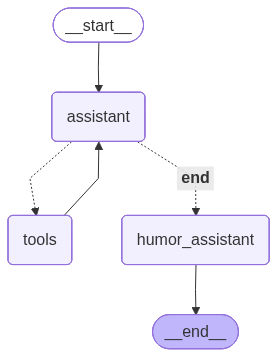

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def getAnswer(result):
    """Extrai respostas considerando múltiplas mensagens no histórico."""
    humor_answer = None
    assistant_answer = None

    # Encontrar a última mensagem do humor_assistant
    for msg in reversed(result["messages"]):
        if isinstance(msg, AIMessage) and not msg.content.startswith('{"'):
            humor_answer = msg.content
            break

    # Encontrar a última resposta JSON do assistant
    for msg in reversed(result["messages"]):
        if isinstance(msg, AIMessage):
            try:
                data = json.loads(msg.content)
                if 'resposta_final' in data:
                    assistant_answer = data['resposta_final']
                    assistant_answer_pensamento = data['pensamento']
                    break
            except json.JSONDecodeError:
                continue

    return {
        "humor_answer": humor_answer,
        "assistant_answer": assistant_answer,
        "assistant_answer_pensamento": assistant_answer_pensamento,
    }

In [ ]:
from langchain_core.messages import HumanMessage

# Função para chat com memória
def chat_with_memory(user_input: str, thread_id: str = None):
    """
    Conversa com o agente mantendo histórico.

    Args:
        user_input: Pergunta do usuário
        thread_id: ID da conversa (se None, cria novo)

    Returns:
        tuple: (resposta_dict, thread_id)
    """
    if thread_id is None:
        thread_id = str(uuid.uuid4())

    config = {"configurable": {"thread_id": thread_id}}

    # Executar o grafo com a configuração de thread
    result = graph.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config=config
    )

    # Extrair resposta final
    final_answer = getAnswer(result)

    return final_answer, thread_id

In [ ]:
# Testar a memória
print("=== TESTE DE MEMÓRIA ===")
thread_id = None

# Primeira pergunta
resposta1, thread_id = chat_with_memory("O que é IRPF?", thread_id)
print(f"Resposta 1: {resposta1['humor_answer']}...")

# Segunda pergunta (relacionada - deve usar contexto)
resposta2, thread_id = chat_with_memory("Quais são os prazos?", thread_id)
print(f"Resposta 2: {resposta2['humor_answer']}...")

# Ver histórico
config = {"configurable": {"thread_id": thread_id}}
state = graph.get_state(config)
print(f"\nMensagens no histórico: {len(state.values['messages'])}")

=== TESTE DE MEMÓRIA ===
Resposta 1: IRPF é o Imposto de Renda da Pessoa Física, o imposto federal cobrado sobre o que você ganha. A Receita Federal cuida do assunto. Todo ano você precisa entregar a Declaração de IRPF para saber se tem imposto a pagar ou se vem restituição. O imposto incide sobre salário, aluguel, ganhos de capital e outras rendas. Dá pra reduzir com deduções como dependentes, educação, saúde e previdência, conforme as regras vigentes.Fique atento ao prazo e às regras de cada dedução....
Resposta 2: Não existe um prazo único pra entregar a declaração do IRPF. O que o documento define é que a restituição referente ao exercício de 2024 será paga em 5 lotes, entre maio e setembro de 2024. Quer confirmar o prazo atual? Confira o calendário oficial da Receita Federal (IRPF) no site da RFB ou a Instrução Normativa correspondente....

Mensagens no histórico: 10


# Interface

In [ ]:
import gradio as gr
import json
from datetime import datetime

In [ ]:
def chat_interface(message, history):
    """Interface de chat para Gradio."""
    global current_thread_id

    try:
        # Usar o sistema com memória
        final_answer, thread_id = chat_with_memory(message, current_thread_id)
        current_thread_id = thread_id

        response = final_answer['humor_answer']

        history.append((message, response))
        return history, "" # Retorna o histórico atualizado e limpa o input

    except Exception as e:
        error_response = f"❌ Erro: {str(e)}"
        history.append((message, error_response))
        return history, ""

In [ ]:
def reset_conversation():
    """Resetar a conversa."""
    global current_thread_id
    current_thread_id = None
    return [], ""  # Retorna histórico vazio e input limpo

In [ ]:
current_thread_id = None

def simple_chat_interface(message, history):
    """Interface simplificada para gr.ChatInterface."""
    global current_thread_id

    try:
        # Usar o sistema com memória
        final_answer, thread_id = chat_with_memory(message, current_thread_id)
        current_thread_id = thread_id

        return final_answer['humor_answer']

    except Exception as e:
        return f"❌ Erro: {str(e)}"

# Interface mais simples com gr.ChatInterface
demo = gr.ChatInterface(
    fn=simple_chat_interface,
    title="🧮 Assistente Multiagente de Imposto de Renda",
    description="Sistema com agente buscador + agente redator para jovens declarantes",
    examples=[
        "O que é IRPF?",
        "Quem deve declarar?",
        "Quais são os prazos?",
        "Como declarar dependentes?"
    ],
    theme=gr.themes.Soft(),
    #avatar_images=("🧑", "🤖")
)

if __name__ == "__main__":
    demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7861


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


* Running on public URL: https://6e2878f341afe62a00.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
demo.close()

Print da interface:
![Print da interface](interface_multiagent.jpeg)

# Avaliação

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=key)


# criar llm juiz
def eval_with_judge(question:str, result:dict):
    final_answer = result #getAnswer(result)
    humor_answer = final_answer['humor_answer']
    #assistant_answer = final_answer['assistant_answer']
    assistant_answer_pensamento = final_answer['assistant_answer_pensamento']

    prompt = ""
    prompt += f"Pergunta: {question}\n"
    prompt += f"Resposta final: {humor_answer}\n"
    prompt += f"Raciocínio: {assistant_answer_pensamento}\n"
    prompt += "Avalie a resposta para pergunta quanto ao raciocínio e a resposta final de 0 a 10.\n"

    response = client.responses.create(
        model=GPT_MODEL,
        input=[
          {
            "role": "developer",
            "content": [
              {
                "type": "input_text",
                "text": """
                Você é um avaliador de respostas certas ou erradas sobre o imposto de renda brasileiro.
                Para uma resposta gerada, você deve avaliar o raciocínio e a resposta final.
                De uma nota de 0 a 10 para o raciocínio, se ele fizer sentido, e de uma nota de 0 a 10 para a resposta final, de acordo com sua factualidade e clareza e explique o motivo da nota.
                O formato da resposta deve ser em json
                {"nota_raciocinio": "numero de 0 a 10", "nota_resposta": "numero de 0 a 10", "motivo": "explicacao do motivo da nota"}.
                """
              }
            ]
          },
          {
            "role": "user",
            "content": [
              {
                "type": "input_text",
                "text": prompt
              }
            ]
          }
        ],
        reasoning={
          "effort": "minimal"
        },
        tools=[],
        store=False
    )

    resposta = response.output[1].content[0].text.strip()  # Retorna a resposta

    return resposta

In [ ]:
current_thread_id = None
thread_id = None

def evaluate_with_react(questions, react_agent, num_questions=NUM_QUESTIONS):
    global current_thread_id, thread_id

    print(f"🎯 AVALIAÇÃO MULTIAGENTES - {num_questions} PERGUNTAS")

    qs = questions.select(range(num_questions))
    #gen, ref = [], []
    results = []

    for i, q in enumerate(tqdm(qs, desc="Processando perguntas")):
        print("\n" + "="*70)
        print(f"PERGUNTA {i+1}/{num_questions}")
        qtext = q['question_text']
        print(f"❓ {qtext}")

        rans = q.get('answer_cleaned', '')
        if isinstance(rans, list):
            rans = ' '.join(rans)
        rans = (rans or "").strip()

        try:
            init_state = {"messages": [HumanMessage(content=qtext)]}

            #print("🤖 Executando agente...")
            #final_state = react_agent.invoke(init_state)

            #print("🔍 Extraindo resposta...")
            #final_answer = getAnswer(final_state)
            current_thread_id = thread_id
            final_answer, thread_id = chat_with_memory(qtext, current_thread_id)

            print(f"\n📝 RESPOSTA FINAL:\n{final_answer['humor_answer']}\n")

            # Calcular avaliaçao com juiz
            #print("📊 Avaliando resposta...")
            avaliacao = eval_with_judge(qtext, final_answer)
            avaliacao = json.loads(avaliacao)  # Converte a resposta em um dicionário Python
            #print(f"Avaliação finalizada")
            results.append({
                "question": qtext,
                "predicted_answer": final_answer["humor_answer"],
                "nota_raciocinio": avaliacao['nota_raciocinio'],
                "nota_resposta": avaliacao['nota_resposta'],
                "logica_juiz": avaliacao['motivo']
            })
            print(f"📊 Avaliação:")
            print(f"  Nota raciocínio: {avaliacao['nota_raciocinio']}")
            print(f"  Nota resposta: {avaliacao['nota_resposta']}")

        # se der erro, resposta ficará vazia e métricas zeradas
        except Exception as e:
            print(f"❌ Erro na pergunta {i+1}: {str(e)}")
            results.append({
                "question": qtext,
                "predicted_answer": "",
                "nota_raciocinio": 0.0,
                "nota_resposta": 0.0,
                "logica_juiz": ""
            })

    return results

Tive que quebrar o processamento das perguntas de 10 em 10 para conseguir gerar.

In [ ]:
questions_1_10 = questions_data.select(range(10))
results1 = evaluate_with_react(questions_1_10, graph, num_questions=10)

with open("results/results_01.json", "w", encoding="utf-8") as f_json:
    json.dump(results1, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO MULTIAGENTES - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?

📝 RESPOSTA FINAL:
Oi! Sobre a Declaração do IRPF 2024 (referente ao ano-calendário de 2023) para quem mora no Brasil:

Você precisa declarar se, em 2023, se encaixou em pelo menos uma dessas situações:
- recebeu rendimentos tributáveis acima do limite de isenção;
- teve ganho de capital na venda de bens ou direitos;
- teve rendimentos de fontes no exterior;
- possuía bens ou direitos com valor total superior a R$ 300 mil (em 31/12/2023);
- fez operações na bolsa de valores, mercadorias, futuros ou mercados similares;
- teve atividade rural com receita bruta acima do patamar previsto;
- outras situações previstas pela lei (por exemplo, rendimentos isentos/tributados na fonte que, somados, exigem a declaração).

Se tiver dúvida sobre o seu caso, consulte a Receita Federal. Ou me conte os detalhes e eu te ajudo a verificar se você precisa declarar.



Processando perguntas:  10%|█         | 1/10 [01:15<11:19, 75.48s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 7

PERGUNTA 2/10
❓ Pessoa física desobrigada pode apresentar a Declaração de Ajuste Anual (DAA)?

📝 RESPOSTA FINAL:
Sim! Mesmo não sendo obrigado, você pode apresentar a Declaração de Ajuste Anual (DAA) de forma facultativa.



Processando perguntas:  20%|██        | 2/10 [02:03<07:56, 59.51s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 7

PERGUNTA 3/10
❓ Contribuinte que é titular ou sócio de empresa está obrigado a apresentar a Declaração de Ajuste Anual do exercício 2024?

📝 RESPOSTA FINAL:
Não. Ser titular ou sócio de empresa não te isenta da obrigatoriedade de entregar a Declaração de Ajuste Anual (DAA). A DAA é obrigatória para pessoa física que, em 2023 (ano-calendário 2023), se encaixe em uma das hipóteses previstas na lei: rendimentos tributáveis acima do limite, ganhos de capital, rendimentos no exterior, bens ou direitos de valor relevante, operações na bolsa, atividade rural com receita bruta, etc. Se não estiver em nenhuma dessas situações, não é obrigado, mas pode entregar a DAA de forma facultativa.



Processando perguntas:  30%|███       | 3/10 [03:06<07:08, 61.17s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 6

PERGUNTA 4/10
❓ Contribuinte, que participou de quadro societário de sociedade anônima ou que foi associado de cooperativa em 2023, deve apresentar, por esses motivos, a Declaração de Ajuste Anual do exercício de 2024?

📝 RESPOSTA FINAL:
Não: ser sócio de uma empresa de capital aberto ou associado de cooperativa em 2023 não cria, por si só, a obrigação de entregar a Declaração de Ajuste Anual (DAA) de 2024 (ano-calendário 2023). A DAA é obrigatória apenas se, em 2023, você se encaixar em alguma condição legal, como: rendimentos tributáveis acima do limite, ganhos de capital, rendimentos no exterior, bens/direitos acima de R$ 300 mil, operações na bolsa, atividade rural com receita, etc. Se não for o seu caso, não é obrigatório, mas você pode entregar a DAA de forma facultativa.



Processando perguntas:  40%|████      | 4/10 [03:48<05:19, 53.23s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 8

PERGUNTA 5/10
❓ Contribuinte que constou como responsável perante a Secretaria Especial da Receita Federal do Brasil (RFB) por Cadastro Nacional da Pessoa Jurídica (CNPJ) de Associações (bairros, creches, clubes etc.) no ano-calendário de 2023, deve apresentar a Declaração de Ajuste Anual do exercício de 2024?

📝 RESPOSTA FINAL:
Não é automático. Ter CNPJ de uma associação (bairro, creche, clube etc.) em 2023 não, por si só, te coloca na obrigação de entregar a Declaração de Ajuste Anual de 2024. A DAA é obrigatória apenas se, em 2023, você se encaixar em algum critério legal, como:
- rendimentos tributáveis acima do limite;
- bens/direitos acima de determinado valor;
- ganhos de capital;
- rendimentos no exterior;
- operações na bolsa;
- atividade rural com receita;
- etc.

Se não se encaixar, não é obrigado, mas pode entregar a DAA de forma facultativa.



Processando perguntas:  50%|█████     | 5/10 [04:27<04:00, 48.10s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 6

PERGUNTA 6/10
❓ Existe limite de idade para a obrigatoriedade ou dispensa de apresentação da Declaração de Ajuste Anual?

📝 RESPOSTA FINAL:
Não, não tem limite de idade. A obrigatoriedade não depende da idade, e sim de critérios legais ligados aos rendimentos, bens e outras situações em 2023. Em resumo: se seus rendimentos/bens atingirem os limites, você precisa declarar; senão, pode ficar de fora. Idade não é parâmetro.



Processando perguntas:  60%|██████    | 6/10 [04:53<02:43, 40.80s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 7

PERGUNTA 7/10
❓ Para verificação da obrigatoriedade de apresentação da Declaração de Ajuste Anual, qual é o critério a ser utilizado para avaliar os bens e direitos, no caso de contribuinte dispensado de apresentar a declaração nos últimos cinco anos?

📝 RESPOSTA FINAL:
Resumo rápido para quem está começando: a regra básica é o total de bens e direitos que você e seus dependentes tinham em 31/12/2023. Se esse somatório exceder R$ 300.000,00, a declaração é obrigatória. Conta tudo: imóveis, veículos, investimentos, dinheiro no exterior, etc.—tudo que estiver em seu nome ou no nome de seus dependentes. Se não chegar a 300 mil, ainda pode haver obrigação por outros motivos, como rendimentos tributáveis ou ganhos de capital, entre outros.



Processando perguntas:  70%|███████   | 7/10 [05:32<02:00, 40.28s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 5

PERGUNTA 8/10
❓ A posse ou a propriedade de bens e direitos relativos à atividade rural de valor superior a R$ 800.000,00, exceto terra nua, obriga o contribuinte à apresentação da Declaração de Ajuste Anual do exercício de 2024?

📝 RESPOSTA FINAL:
Não é assim: ter bens rurais acima de R$ 800.000,00 não, por si só, obriga a apresentar a Declaração de Ajuste Anual (DAA) de 2024.

A DAA é obrigatória em 2023 quando:

- (a) o total de bens/direitos em seu nome e de seus dependentes supera R$ 300.000,00; ou
- (b) houver rendimentos relevantes, ganhos de capital, rendimentos no exterior, ou outras hipóteses previstas na lei.

Para atividade rural, também pode haver obrigação de entregar a LCDPR caso a receita bruta da atividade rural tenha excedido o teto aplicável (com limites específicos de receita).



Processando perguntas:  80%|████████  | 8/10 [06:51<01:45, 52.61s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 6

PERGUNTA 9/10
❓ O contribuinte deve apresentar uma Declaração de Ajuste Anual para cada fonte pagadora dos rendimentos que auferir?

📝 RESPOSTA FINAL:
É simples: faça apenas uma Declaração de Ajuste Anual (DAA). Consolide todos os seus rendimentos de todas as fontes pagadoras e use os informes de rendimentos de cada uma para preencher a DAA.



Processando perguntas:  90%|█████████ | 9/10 [07:18<00:44, 44.51s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 9

PERGUNTA 10/10
❓ Dependente que possui depósito em conta de poupança em valor superior a R$ 800.000,00 está obrigado a declarar?

📝 RESPOSTA FINAL:
Não. O dependente não precisa declarar só por ter poupança de 800 mil. A Declaração de Ajuste Anual é única por contribuinte. Se houver dependentes, os bens deles entram na avaliação da obrigação do declarante. Se o total de bens do declarante mais os dependentes passar de R$ 300.000,00, o declarante fica obrigado a apresentar a DAA; o dependente não declara separadamente apenas por esse motivo.



Processando perguntas: 100%|██████████| 10/10 [08:02<00:00, 48.27s/it]

📊 Avaliação:
  Nota raciocínio: 5
  Nota resposta: 4


In [ ]:
questions_10_20 = questions_data.select(range(10, 20))
results2 = evaluate_with_react(questions_10_20, graph, num_questions=10)

with open("results/results_02.json", "w", encoding="utf-8") as f_json:
    json.dump(results2, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO MULTIAGENTES - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Contribuinte com doença grave está desobrigado de apresentar a declaração?

📝 RESPOSTA FINAL:
Não. A doença grave, por si só, não dispensa automaticamente a Declaração de Ajuste Anual (DAA). A dispensa ocorre apenas se você atender a uma das hipóteses previstas na Lei 14.754/2023 (caput/incisos I a XI) ou se for dependente em DAA apresentada por outra pessoa.



Processando perguntas:  10%|█         | 1/10 [00:40<06:00, 40.10s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 6

PERGUNTA 2/10
❓ O que se considera como opção pelo desconto simplificado?

📝 RESPOSTA FINAL:
Desconto simplificado é um atalho na sua Declaração de Ajuste Anual. Em vez de usar várias deduções (despesas com saúde, educação, dependentes, etc.), você escolhe o desconto fixo de 20% da base de cálculo do IR, dentro do teto definido pela Receita Federal para aquele ano. Com isso, não precisa comprovar despesas específicas — basta aplicar o benefício de 20% (até o teto). É uma boa opção para quem não tem muitas despesas dedutíveis ou quer simplificar o preenchimento. Se estiver na dúvida, compare com o modo detalhado para ver qual fica mais vantajoso para você.



Processando perguntas:  20%|██        | 2/10 [02:37<11:22, 85.35s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 7

PERGUNTA 3/10
❓ Um cônjuge ou companheiro que apresenta declaração utilizando-se das deduções legais pode incluir um dependente comum se o outro cônjuge ou companheiro apresentou a declaração utilizando-se do desconto simplificado e não incluiu tal dependente?

📝 RESPOSTA FINAL:
Pode sim: o dependente comum pode constar na DAA de um dos cônjuges/companheiros que optar por deduções legais, desde que ele não tenha sido incluído na DAA do outro no mesmo ano. O fato de o outro cônjuge ter usado desconto simplificado não impede a inclusão pelo primeiro, pois cada declaração é individual e o dependente não pode aparecer em mais de uma DAA no mesmo ano.



Processando perguntas:  30%|███       | 3/10 [03:35<08:30, 72.92s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 6

PERGUNTA 4/10
❓ Quem pode optar pelo desconto simplificado na apresentação da Declaração de Ajuste Anual?

📝 RESPOSTA FINAL:
Pode optar pelo desconto simplificado qualquer pessoa física que entregue a Declaração de Ajuste Anual (DAA). Não precisa ter renda mínima nem ter dependentes. O desconto simplificado substitui as deduções detalhadas por uma dedução fixa de 20% da base de cálculo, sujeita a teto definido pela Receita Federal. Caso escolha o desconto simplificado, não é possível acumular as deduções detalhadas.



Processando perguntas:  40%|████      | 4/10 [04:11<05:51, 58.60s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 7

PERGUNTA 5/10
❓ O contribuinte que possui mais de uma fonte pagadora pode optar pelo desconto simplificado?

📝 RESPOSTA FINAL:
Pode sim! Se você tem mais de uma fonte pagadora, pode optar pelo desconto simplificado na Declaração de Ajuste Anual. Ele é aplicado sobre a base de cálculo e substitui as deduções detalhadas. Atenção: ao escolher o desconto simplificado, não dá para usar deduções detalhadas (saúde, educação, dependentes, etc.).



Processando perguntas:  50%|█████     | 5/10 [04:41<03:59, 47.99s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 7

PERGUNTA 6/10
❓ O contribuinte que em 2023 recebeu rendimentos tributáveis na Declaração de Ajuste Anual e obteve receita da atividade rural, mas com resultado negativo (prejuízo), pode optar pelo desconto simplificado?

📝 RESPOSTA FINAL:
Pode sim, mesmo com prejuízo na atividade rural, usar o desconto simplificado. Ele é de 20% da base de cálculo da sua DAA, até o teto definido pela Receita Federal. Se a base de cálculo for zero ou negativa, o desconto fica zero. E mesmo com renda de outras fontes, você pode aplicar o desconto simplificado.



Processando perguntas:  60%|██████    | 6/10 [05:09<02:45, 41.27s/it]

📊 Avaliação:
  Nota raciocínio: 5
  Nota resposta: 4

PERGUNTA 7/10
❓ O contribuinte que optar pelo desconto simplificado deve preencher as fichas “Pagamentos Efetuados” e “Doações Efetuadas”?

📝 RESPOSTA FINAL:
Se você optar pelo Desconto Simplificado, não precisa preencher as fichas Pagamentos Efetuados e Doações Efetuadas. As deduções detalhadas são substituídas por um desconto fixo de 20% da base de cálculo. Deixe essas fichas zeradas ou em branco, conforme o sistema da Receita Federal.



Processando perguntas:  70%|███████   | 7/10 [05:33<01:46, 35.56s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 8

PERGUNTA 8/10
❓ O desconto simplificado substitui a parcela de isenção referente a rendimentos de aposentadoria recebidos por contribuinte maior de 65 anos?

📝 RESPOSTA FINAL:
Não. O desconto simplificado não substitui a isenção para rendimentos de aposentadoria de quem tem 65 anos ou mais. O desconto simplificado é uma dedução fixa de 20% da base de cálculo. Já a isenção/parcela para 65 anos é um benefício específico dos rendimentos de aposentadoria e tem regras próprias.



Processando perguntas:  80%|████████  | 8/10 [06:18<01:17, 38.65s/it]

📊 Avaliação:
  Nota raciocínio: 9
  Nota resposta: 9

PERGUNTA 9/10
❓ O contribuinte que optar pelo desconto simplificado pode excluir os honorários advocatícios pagos referentes a rendimentos recebidos acumuladamente, por decisão judicial?

📝 RESPOSTA FINAL:
Se escolher o desconto simplificado, não dá pra deduzir honorários de advogado nem outras despesas específicas. A dedução é fixa: 20% da base de cálculo, com um teto definido pela Receita.



Processando perguntas:  90%|█████████ | 9/10 [06:57<00:38, 38.74s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 6

PERGUNTA 10/10
❓ O contribuinte que optar pelo desconto simplificado pode excluir as despesas com condomínio, taxas, impostos, em relação a aluguéis recebidos?

📝 RESPOSTA FINAL:
Resumo rápido: ao optar pelo desconto simplificado, você não pode deduzir despesas específicas (condomínio, taxas ou impostos sobre aluguéis). O desconto simplificado é uma dedução fixa de 20% da base de cálculo, dentro do teto, substituindo as deduções detalhadas. Se quiser deduzir essas despesas, escolha o modelo completo.



Processando perguntas: 100%|██████████| 10/10 [07:23<00:00, 44.36s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 6


In [ ]:
questions_20_30 = questions_data.select(range(20, 30))
results3 = evaluate_with_react(questions_20_30, graph, num_questions=10)

with open("results/results_03.json", "w", encoding="utf-8") as f_json:
    json.dump(results3, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO MULTIAGENTES - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Qual é o prazo de apresentação da Declaração de Ajuste Anual do exercício de 2024?

📝 RESPOSTA FINAL:
Fala, pessoal! O prazo para enviar a declaração do IR é até o último dia útil de abril de 2024. É para o exercício de 2024 (ano-calendário 2023).



Processando perguntas:  10%|█         | 1/10 [01:04<09:42, 64.67s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 5

PERGUNTA 2/10
❓ Qual é o prazo de apresentação da Declaração de Ajuste Anual para a pessoa física ausente do Brasil?

📝 RESPOSTA FINAL:
Se você está fora do Brasil, o prazo é o mesmo de quem está aqui: até o último dia útil de abril do ano seguinte aos rendimentos. Para o exercício de 2024 (rendimentos de 2023), o prazo é 30 de abril de 2024. Fica ligado: começa já pra não deixar pra última hora.



Processando perguntas:  20%|██        | 2/10 [01:39<06:15, 46.88s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 5

PERGUNTA 3/10
❓ Contribuinte que na data final da apresentação da declaração se encontra em viagem, fora de seu domicílio fiscal, tem direito à prorrogação desse prazo?

📝 RESPOSTA FINAL:
Não rola prorrogação automática só porque você está viajando ou fora do domicílio fiscal. O prazo é o mesmo pra todo mundo: até o último dia útil de abril do ano seguinte aos rendimentos. No exercício de 2024, é até 30 de abril de 2025.



Processando perguntas:  30%|███       | 3/10 [02:30<05:41, 48.74s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 5

PERGUNTA 4/10
❓ Qual é a penalidade aplicável na apresentação da Declaração de Ajuste Anual depois do prazo ou na sua não apresentação?


Processando perguntas:  40%|████      | 4/10 [03:18<04:51, 48.59s/it]

❌ Erro na pergunta 4: Invalid control character at: line 1 column 354 (char 353)

PERGUNTA 5/10
❓ O contribuinte não obrigado à apresentação da Declaração de Ajuste Anual está sujeito à multa por atraso na entrega da declaração?

📝 RESPOSTA FINAL:
Resumo direto, em linguagem simples:

- Não tem multa por atraso se você não é obrigado a entregar a DAA.
- A multa só aparece se houver obrigação de apresentar ou se entregar após o prazo.
- Valor da multa: 1% ao mês (ou fração), mínimo de R$ 165,74 e máximo de 20% do IR devido.
- Reduções: 50% se entregar após o prazo mas antes de abrir fiscalização; 75% se entregar conforme intimação.



Processando perguntas:  50%|█████     | 5/10 [03:55<03:42, 44.58s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 5

PERGUNTA 6/10
❓ De quais formas posso preencher a Declaração de Ajuste Anual (DAA) do ano-calendário de 2023, exercício de 2024?

📝 RESPOSTA FINAL:
Formas de fazer a sua IRPF:

- PGD (Programa Gerador de Declaração): você instala no PC, preenche e envia pela ReceitaNet. Bom se prefere editar offline.

- Declaração de Ajuste Anual Pré-Preenchida: entra no portal gov.br, a declaração já vem com várias informações preenchidas. Você só precisa revisar/corrigir o que for necessário. Vai exigir autenticação com Identidade Digital.

- Declaração pela Internet (IRPF Online): preenche direto no navegador, sem instalar nada, e envia pela internet. Fácil pra fazer direto de casa.



Processando perguntas:  60%|██████    | 6/10 [04:54<03:17, 49.30s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 8

PERGUNTA 7/10
❓ Quem pode apresentar a Declaração de Ajuste Anual em nome do contribuinte?

📝 RESPOSTA FINAL:
Você pode apresentar a DAA de duas formas:

- Você mesmo apresenta a DAA em seu nome (contribuinte).
- Você autoriza outra pessoa física para elaborar e transmitir a DAA (procuração/representação).

Requisitos da autorização:
- Pode ser concedida a apenas uma pessoa física.
- Dura até 6 meses, podendo ser renovada.
- Pode ser revogada a qualquer momento.
- O autorizado precisa ter conta gov.br com Identidade Digital nos níveis Ouro ou Prata.
- A autorização vale para a DAA (inclui acesso à DAA pré-preenchida) e para a DAA final.



Processando perguntas:  70%|███████   | 7/10 [05:47<02:31, 50.64s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 7

PERGUNTA 8/10
❓ Como acessar a Declaração de Ajuste Anual (DAA) Pré-Preenchida?

📝 RESPOSTA FINAL:
Como acessar a Declaração de Ajuste Anual Pré-Preenchida (IRPF Pré-Preenchido)

- Passo 1: Acesse gov.br e faça login com Identidade Digital de nível Ouro ou Prata.
- Passo 2: Abra o serviço Declaração de Ajuste Anual Pré-Preenchida (IRPF Pré-Preenchido).
- Passo 3: Escolha o ano (ex.: 2023). Se for você quem declara, usa seus dados; se for representante, use a procuração conforme IN 2066.
- Passo 4: Revise os dados pré-preenchidos (rendimentos, deduções, bens, dívidas) e edite/inclusões conforme necessário.
- Passo 5: Grave e transmita a DAA pela internet (PGD/IRPF Online).



Processando perguntas:  80%|████████  | 8/10 [06:19<01:29, 44.74s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 8

PERGUNTA 9/10
❓ Quais são as informações constantes na Declaração de Ajuste Anual Pré-Preenchida?

📝 RESPOSTA FINAL:
Resumo simples para quem tá começando:

- O que já vem na Declaração de Ajuste Anual Pré-Preenchida: 
  1) Rendimentos recebidos no ano (tributáveis, isentos/não tributáveis e sujeitos à tributação exclusiva/definitiva);
  2) Deduções (inclui dependentes e despesas elegíveis);
  3) Bens e direitos existentes no Brasil ou no exterior em 31/12/2022 e 31/12/2023;
  4) Dívidas e ônus reais existentes em 31/12/2022 e 31/12/2023.

- Acesso: no portal gov.br com Identidade Digital nos níveis Ouro ou Prata.

- O que você pode fazer: revisar, editar, incluir ou excluir informações antes de transmitir.

- Lembrete: a veracidade dos dados continua com você, contribuinte.



Processando perguntas:  90%|█████████ | 9/10 [06:51<00:40, 40.79s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 6

PERGUNTA 10/10
❓ Quem pode utilizar a Declaração de Ajuste Anual Pré-Preenchida?

📝 RESPOSTA FINAL:
Você pode usar a Declaração de Ajuste Anual Pré-Preenchida de três jeitos:
1) você mesmo, com Identidade Digital de nível Ouro ou Prata;
2) um representante autorizado, com procuração eletrônica conforme IN 2.066/2022;
3) outra pessoa física autorizada por você, por meio de procuração (com os requisitos de acesso).



Processando perguntas: 100%|██████████| 10/10 [07:18<00:00, 43.86s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 7


In [ ]:
questions_30_40 = questions_data.select(range(30, 40))
results4 = evaluate_with_react(questions_30_40, graph, num_questions=10)

with open("results/results_04.json", "w", encoding="utf-8") as f_json:
    json.dump(results4, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO MULTIAGENTES - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Quem não pode preencher ou apresentar a declaração por meio do “Meu Imposto de Renda”?


Processando perguntas:  10%|█         | 1/10 [00:41<06:17, 42.00s/it]

❌ Erro na pergunta 1: Unterminated string starting at: line 1 column 429 (char 428)

PERGUNTA 2/10
❓ Onde obter o programa IRPF 2024?

📝 RESPOSTA FINAL:
Para pegar o PGD IRPF 2024:

- Acesse receita.gov.br.
- Vá em Imposto de Renda → IRPF → Programas → Programa Gerador da Declaração IRPF 2024.
- Baixe a versão correspondente ao seu sistema (Windows, macOS, etc.).

Se preferir, use o portal gov.br que te leva direto para a página da Receita Federal.



Processando perguntas:  20%|██        | 2/10 [01:03<03:59, 29.91s/it]

📊 Avaliação:
  Nota raciocínio: 9
  Nota resposta: 9

PERGUNTA 3/10
❓ Quais são os requisitos necessários para a utilização do programa IRPF 2024?

📝 RESPOSTA FINAL:
Não dá pra usar o IRPF Online para preencher/presentar a DAA nesses casos:

- Espólio ou Declaração Final de Espólio — precisa de uma DAA específica para espólio, geralmente via mídia removível.
- Contribuinte sem CPF/Identidade Digital válidos ou sem procuração adequada quando há representação por terceiros.



Processando perguntas:  30%|███       | 3/10 [02:04<05:10, 44.35s/it]

❌ Erro na pergunta 3: 'nota_raciocinio'

PERGUNTA 4/10
❓ Como instalar o programa IRPF 2024?

📝 RESPOSTA FINAL:
Passos simples para instalar o PGD IRPF 2024 (pra quem está declarando pela primeira vez):

1) Acesse o site oficial da Receita Federal: receita.gov.br → Imposto de Renda → IRPF → Programas → Programa Gerador da Declaração IRPF 2024.
2) Baixe a versão correspondente ao seu sistema operacional (geralmente Windows; para Mac/Linux, veja o que o site oferece).
3) Rode o instalador baixado e siga as instruções na tela para concluir a instalação.
4) Abra o PGD IRPF 2024, escolha o exercício 2024 e o tipo de declaração (original ou retificadora).
5) Garanta privilégios de administrador, se solicitado, e instale qualquer componente adicional recomendado pelo instalador.
6) Conecte-se à Internet conforme necessário para transmissão via ReceitaNet ao enviar a declaração.

Observação: se estiver usando Mac ou Linux e não houver versão nativa, verifique as opções de compatibilidade no si

Processando perguntas:  40%|████      | 4/10 [02:31<03:43, 37.18s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 7

PERGUNTA 5/10
❓ Quais são os meios a serem utilizados para transmissão da Declaração de Ajuste Anual do ano-calendário de 2023, exercício de 2024?

📝 RESPOSTA FINAL:
Meios de transmissão da DAA 2024 (ano-calendário 2023):
- PGD (Programa Gerador da Declaração): você cria a DAA no PC e envia pela ReceitaNet.
- IRPF Online: faz a declaração pela Internet, direto no navegador.
- Declaração de Ajuste Anual Pré-Preenchida: pode ser enviada pelo PGD ou pelo IRPF Online, depois de revisar.
- Retificações: usam os mesmos meios (PGD ou IRPF Online) para enviar a DAA retificadora.

Observação: para terceiros, a transmissão pode ocorrer por procuração/representação, conforme IN 2.066/2022.



Processando perguntas:  50%|█████     | 5/10 [02:57<02:46, 33.36s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 7

PERGUNTA 6/10
❓ Onde obter outras informações sobre a transmissão da declaração pela Internet utilizando o Receitanet?

📝 RESPOSTA FINAL:
Para transmitir a Declaração de Ajuste Anual pela Internet (ReceitaNet), confira estas fontes:

- Receita Federal: IRPF > Programas/IRPF e a página sobre ReceitaNet.
- Guia IRPF 2024: capítulos sobre transmissão e meios de apresentação.
- Portal gov.br: links para IRPF Online e DAA Pré-Preenchida.
- Instrução Normativa RFB nº 2.066/2022: procuração para acesso à DAA, se houver representante.

Dica prática: se for a sua primeira declaração, comece pelo Guia IRPF 2024 e use o IRPF Online ou a DAA Pré-Preenchida via Gov.br para facilitar.



Processando perguntas:  60%|██████    | 6/10 [03:44<02:31, 38.00s/it]

📊 Avaliação:
  Nota raciocínio: 8
  Nota resposta: 8

PERGUNTA 7/10
❓ Qual o local de apresentação, no prazo, da Declaração de Ajuste Anual do exercício de 2024?

📝 RESPOSTA FINAL:
Onde entregar: pela Internet — usando o IRPF Online ou o Programa Gerador da Declaração (PGD) com ReceitaNet. A Declaração de Ajuste Anual Pré-Preenchida também pode ser enviada pelo IRPF Online ou pelo PGD, após você revisar. Em caso de espólio, pode ser entregue em mídia removível.

Prazo: até o último dia útil de abril de 2024 (exercício de 2024, ano-calendário 2023).



Processando perguntas:  70%|███████   | 7/10 [04:12<01:43, 34.53s/it]

📊 Avaliação:
  Nota raciocínio: 6
  Nota resposta: 6

PERGUNTA 8/10
❓ Quem deve transmitir a Declaração de Ajuste Anual do exercício de 2024 com a utilização de certificado digital ou com Identidade Digital Ouro ou Prata no portal gov.br?

📝 RESPOSTA FINAL:
Para transmitir a DAA, você tem duas opções simples:

- Transmitir você mesmo:
  • com certificado digital ICP-Brasil ou com Identidade Digital Ouro/Prata no gov.br;
  • usando o IRPF Online ou o PGD/ReceitaNet.

- Transmitir por alguém autorizado:
  • via procuração eletrônica conforme IN 2.066/2022;
  • o representante precisa ter Identidade Digital Ouro ou Prata;
  • a procuração deve permitir a transmissão da DAA.

Resumo: você pode enviar a DAA sozinho ou por meio de um autorizado, desde que tenha as credenciais e permissões corretas.



Processando perguntas:  80%|████████  | 8/10 [04:49<01:11, 35.54s/it]

📊 Avaliação:
  Nota raciocínio: 7
  Nota resposta: 8

PERGUNTA 9/10
❓ Qual é o local de apresentação da Declaração de Ajuste Anual para a pessoa física residente no Brasil que esteja no exterior?

📝 RESPOSTA FINAL:
O envio da declaração é pela internet. Você pode transmitir a Declaração de Ajuste Anual pelo IRPF Online ou pelo PGD/ReceitaNet, mesmo se estiver no exterior. Também dá pra usar a DAA Pré-Preenchida pelo portal gov.br, desde que você tenha a autenticação correta (Identidade Digital Ouro/Prata) ou uma procuração válida para terceiros.



Processando perguntas:  90%|█████████ | 9/10 [05:18<00:33, 33.49s/it]

❌ Erro na pergunta 9: 'nota_raciocinio'

PERGUNTA 10/10
❓ Qual é o local de apresentação da Declaração de Ajuste Anual do exercício de 2024 apresentada fora do prazo?

📝 RESPOSTA FINAL:
Formas de enviar a sua declaração:
- IRPF Online
- PGD (Programa Gerador da Declaração) via ReceitaNet
- Declaração de Ajuste Anual Pré-Preenchida pelo portal gov.br

Se alguém autorizado for enviar em seu lugar, é possível por meio de procuração (conforme IN 2.066/2022).

Observação: atraso gera multa, mas o local de envio não muda.



Processando perguntas: 100%|██████████| 10/10 [05:42<00:00, 34.26s/it]

❌ Erro na pergunta 10: Invalid \escape: line 4 column 708 (char 755)


In [ ]:
result = results1 + results2 + results3 + results4 #+ results5 # Concatena os resultados
len(result)

40

In [ ]:
with open("results/results.json", "w", encoding="utf-8") as f_json:
    json.dump(result, f_json, ensure_ascii=False, indent=2)

## Métricas finais

In [ ]:
notas_raciocinio = [float(r["nota_raciocinio"]) for r in result]  # Lista com as notas de raciocínio
notas_resposta = [float(r["nota_resposta"]) for r in result]  # Lista com as notas de resposta

print(f"Média das notas de raciocínio: {np.mean(notas_raciocinio):.2f}")
print(f"Média das notas de resposta: {np.mean(notas_resposta):.2f}")

Média das notas de raciocínio: 5.92
Média das notas de resposta: 5.80


In [ ]:
import matplotlib.pyplot as plt

# histograma das notas
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Cria uma figura com 1 linha e 2 colunas

axes[0].hist(notas_raciocinio, bins=10, color='blue', alpha=0.5)  # Histograma das notas de raciocínio
axes[0].set_title("Notas de raciocínio")
axes[0].set_xlabel("Nota")
axes[0].set_ylabel("Frequência")

axes[1].hist(notas_resposta, bins=10, color='green', alpha=0.5)  # Histograma das notas de resposta
axes[1].set_title("Notas de resposta")
axes[1].set_xlabel("Nota")
axes[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()

<Figure size 1200x400 with 2 Axes>